### Directed Acyclic Graphs (인과관계를 나타내는 비순환 그래프)
- X -> Y 외 다른 경로가 있을 떄, 순환 고리는 없다고 가정한다. (비순환 구조)
  
- 순환 그래프를 고려하지 않는 이유는 수학적인 증명이 어렵기 때문에 비순환 그래프로 가정하는 것이다.
  
- 다음 챕터인 Potential Outcomes (잠재적 결과 $Y_0$ or $Y_1$) 는 처치 변수($X$)와 독립적인 관계(랜덤화)를 가정하는데, 다른 경로가 생기게 되면 $X$ 와 $Y$간 편향이 생기기 때문에 인과그래프를 잘 설계하는 것이 중요하다.

In [7]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("fivethirtyeight")

#### Causal Diagram
- 인과 그래프의 다이어그램은 크게 3가지의 종류가 있다.
  
    - Mediator (Chain, Indirect Causal Effect)
  
    - Confounder (Fork)
  
    - Collider (Immorality)

##### 1. Mediator
- 매개변수인 C에 의해 X -> Y 영향에 간접적인 영향을 준다.

 - 따라서 Mediator Variable는 간접적인 영향으로 인해 통제하지 않아도 된다.
 
 - 하지만, 만약 $Y$에 영향을 주는 $X$의 직접적인 영향만을 추정하기 위해선 매개변수를 통제해야 한다.

 - 아래 기사 내용에 자세히 설명되어 있다.
    
    - https://journals.lww.com/epidem/fulltext/2017/07000/confounders,_mediators,_or_colliders__what_types.11.aspx

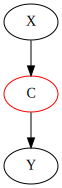

In [5]:
# Mediator Graph
g = gr.Digraph()

g.edge("X", "C")
g.edge("C", "Y")
g.node("C", "C", color="red")
g

##### 2. Confounder
- 교란변수인 C가 X에도 영향을 주고, Y에도 영향을 주는 경우를 말한다.
  
- C를 통제하여 X에서 Y로 가는 다른 경로를 차단해야 된다. $(Y \perp X|C)$

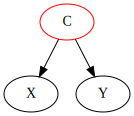

In [15]:
# Confounder
g = gr.Digraph()

g.edge("C", "X")
g.edge("C", "Y")
g.node("C", color="red")
g

##### 3. Collider
- 처치(X)와 결과(Y)가 C에 영향을 주는 경우를 말한다.
  
- Confounder와 달리 C를 통제해서는 안된다. C를 통제하면 오히려 X와 Y의 경로를 열어주는 문제가 생기게 된다.
  
- C를 통제하면 안되는 이유
  
    - Talent와 Beauty가 Movie Star (C) 에 영향을 준다고 가정해보자. Talent(재능) 이 많을 수록 Movie Star(스타) 가 될 가능성이 높으며, Beauty(외모)는 Movie Star(스타)가 되는데 많은 영향을 줄 것이다.

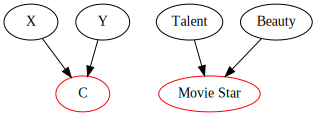

In [60]:
# Collider
g = gr.Digraph()

g.edge("X", "C")
g.edge("Y", "C")
g.node("C", color="red")

g.edge("Talent", "Movie Star")
g.edge("Beauty", "Movie Star")
g.node("Movie Star", color="red")
g

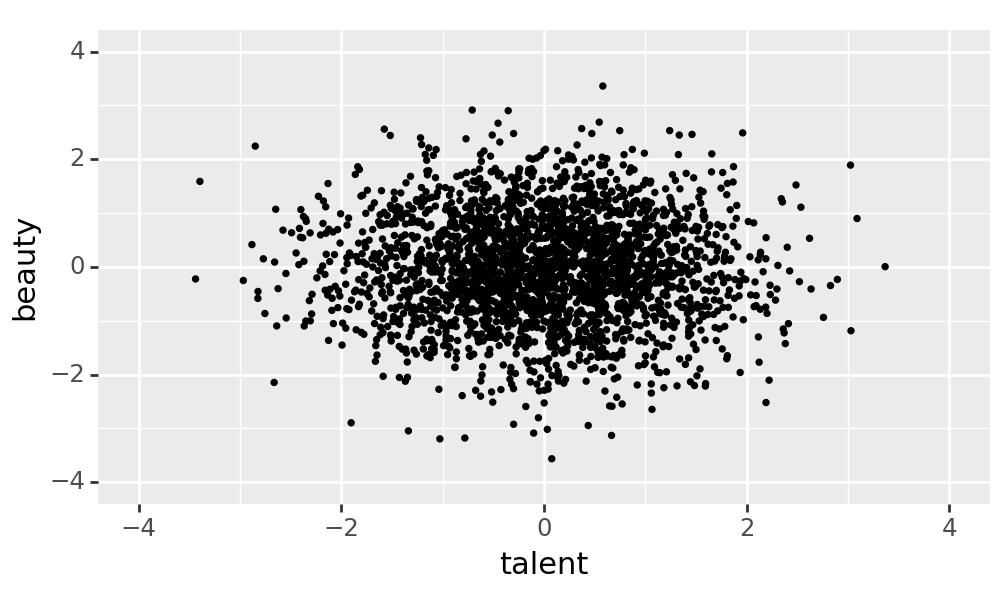

<Figure Size: (500 x 300)>

In [70]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from itertools import combinations 
import plotnine as p
from stargazer.stargazer import Stargazer
import plotnine

# read data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
def read_data(file): 
    return pd.read_stata("https://github.com/scunning1975/mixtape/raw/master/" + file)



start_is_born = pd.DataFrame({
    'beauty': np.random.normal(size=2500),
    'talent': np.random.normal(size=2500)})
    
start_is_born['score'] = start_is_born['beauty'] + start_is_born['talent']
start_is_born['c85'] = np.percentile(start_is_born['score'], q=85)
start_is_born['star'] = 0
start_is_born.loc[start_is_born['score']>start_is_born['c85'], 'star'] = 1
start_is_born.head()


lm = sm.OLS.from_formula('beauty ~ talent', data=start_is_born).fit()

p.ggplot(start_is_born, p.aes(x='talent', y='beauty')) +    p.geom_point(size = 0.5) +    p.xlim(-4, 4) +    p.ylim(-4, 4) + p.theme(figure_size=(5, 3))


- Selection Bias: 위 그래프를 보면 실제로 Talent와 Beauty 관계는 독립적이지만, 스타(C)를 통제할 때 가짜 음의관계로 인한 편향을 유발시킬 수 있다.
  
- 가짜 상관관계가 생성되는 이유는 스타성이 없는 사람들은 Talent와 Beauty의 값이 스타성이 있는 사람들에 비해 보통 하위에 위치하기 때문이다.
  
- 스타(C)를 통제함으로써 X->Y간 또 다른 경로가 추가되므로 Colliider 상황에서 C를 통제해서는 안된다.

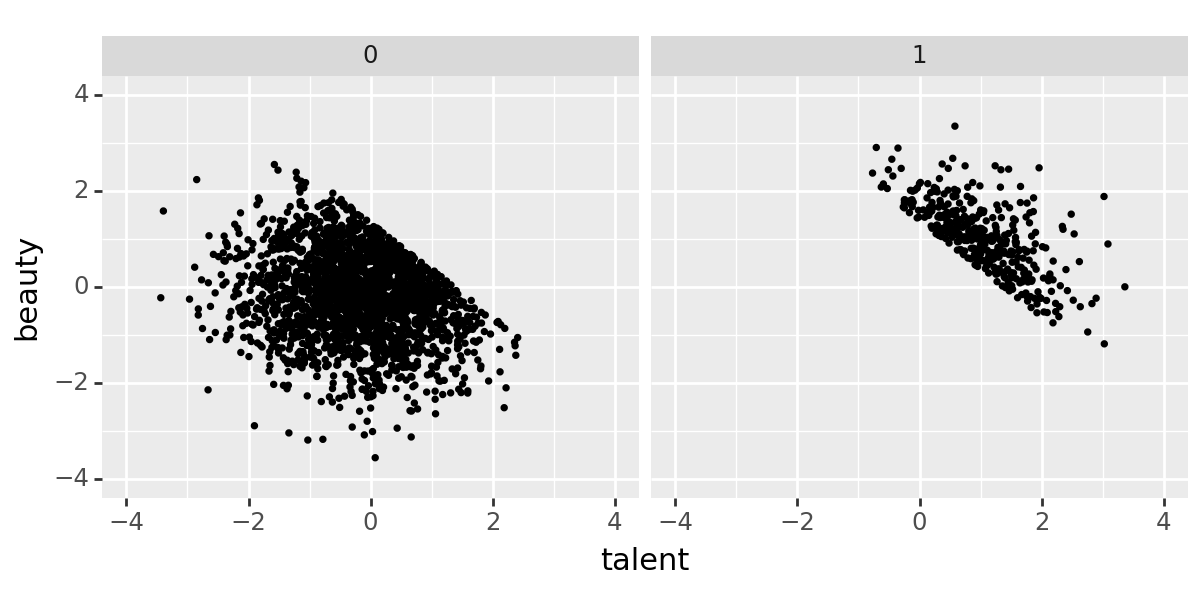

<Figure Size: (600 x 300)>

In [72]:
p.ggplot(start_is_born, p.aes(x='talent', y='beauty')) +    p.geom_point(size = 0.5) +    p.xlim(-4, 4) +    p.ylim(-4, 4) + p.facet_wrap("~ star",ncol=2)+ p.theme(figure_size=(6, 3))
